In [1]:
# | default_exp conv

%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from icecream import ic

device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
)
device

device(type='mps')

In [3]:
def load_cifar():
    train = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )

    val = datasets.CIFAR10(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )
    return train, val


def data_loaders(train_data, val_data, batch_size):
    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    val_loader = DataLoader(
        val_data, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    return train_loader, val_loader


training_data, validation_data = load_cifar()
#training_data, validation_data = load_fashion_mnist()
training_loader, validation_loader = data_loaders(
    training_data, validation_data, batch_size=10
)
x_train_var = np.var(training_data.data / 255.0)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def display_image_grid(x):
    x = make_grid(x.cpu().detach() + 0.5)
    x = x.numpy()
    ic(x.shape)
    ic(np.transpose(x,(1,2,0)).shape)
    fig = plt.imshow(np.transpose(x, (1, 2, 0)), interpolation="nearest")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

ic| bx.shape: torch.Size([10, 3, 32, 32])
ic| x.shape: (3, 70, 274)
ic| np.transpose(x,(1,2,0)).shape: (70, 274, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.5].


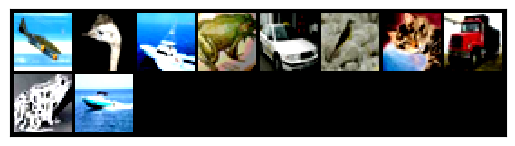

In [5]:
bx, _ =next(iter(training_loader))
bx = bx.to(device)
ic(bx.shape)
display_image_grid(bx)

## Convolution basics

https://www.telesens.co/2017/09/17/cnn_derivatives/

In [6]:
def show_image(image_tensor, title: str):
    # Convert the image tensor to a NumPy array
    image_np = image_tensor.squeeze().cpu().detach().numpy()
    image_np = np.transpose(image_np, (1, 2, 0))  # Rearrange dimensions to HWC
    
    # normalized tze image, because imshow can take value from 0 .. 1
    image_np_norm = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    

    # Display the image using matplotlib
    plt.figure(figsize=(1, 1))
    plt.imshow(image_np_norm)
    plt.title(title)
    plt.axis("off")  # Turn off axis labels
    plt.show()



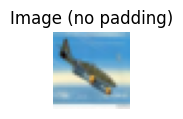

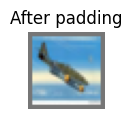

ic| input_height: 36
    input_width: 36
    kernel_height: 3
    kernel_width: 3
ic| output_height: 34, output_width: 34


In [7]:
stride = 1
kernel_size = 3
padding = 2
in_channels = 3
out_channels = 3

x = bx[0].unsqueeze(0)
show_image(x, "Image (no padding)")
if padding>0:
    x = F.pad(x, (padding, padding, padding, padding))
    show_image(x, "After padding")


batch_size, in_channels, input_height, input_width = x.size()
#out_channels, _, kernel_height, kernel_width = kernel_weight.size()
kernel_height, kernel_width = kernel_size, kernel_size
ic(input_height, input_width,kernel_height, kernel_width)


# Calculate the dimensions of the output tensor
output_height = (input_height - kernel_height) // stride + 1
output_width = (input_width - kernel_width) // stride + 1
ic(output_height, output_width)

# Initialize the output tensor
output = torch.zeros(batch_size, out_channels, output_height, output_width)

ic| vertical_line_kernel.shape: torch.Size([3, 3, 3, 3])


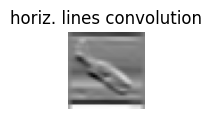

In [8]:
# Convolution logic
vertical_line_kernel = torch.tensor(
    [[[[1, 0, -1], [1, 0, -1], [1, 0, -1]]]], dtype=torch.float32
).to(device)
# Replicate the kernel for each input channel (R, G, B) and each output channel. 
vertical_line_kernel = vertical_line_kernel.repeat(3, 3, 1, 1)
ic(vertical_line_kernel.shape)

horiz_line_kernel = torch.tensor([[[1, 1, 1], [0, 0, 0], [-1, -1, -1]]], dtype=torch.float32).to(device).repeat(3,3,1,1)

# Laplacian filter, which detects edges regardless of their orientation.
laplacian_kernel = torch.tensor([[[ 0,  1,  0],
 [ 1, -4,  1],
 [ 0,  1,  0]]], dtype=torch.float32).to(device).repeat(3,3,1,1)

kernel_weight = vertical_line_kernel
convol_type: str = 'vertical lines' 
kernel_weight = horiz_line_kernel
convol_type: str = 'horiz. lines' 
#kernel_weight = laplacian_kernel
#convol_type: str = 'laplacian' 
#kernel_bias = torch.randn(out_channels).to(device)

for i in range(0, input_height - kernel_height + 1, stride):
    for j in range(0, input_width - kernel_width + 1, stride):
        region = x[:, :, i : i + kernel_height, j : j + kernel_width]              
        #rk = region * kernel_weight
        #output[:, :, i // stride, j // stride] = torch.sum(rk, dim=(1,2,3)) #+ kernel_bias
        output[:, :, i // stride, j // stride]=torch.tensordot(region, kernel_weight,dims=([1,2,3], [1, 2, 3]))#+kernel_bias

show_image(output, f"{convol_type} convolution")

ic| conv.weight.shape: torch.Size([3, 3, 3, 3])


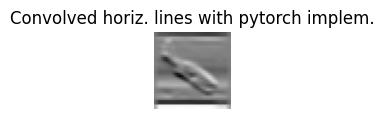

In [9]:
# Check results with pytorch implementation
# Define a convolution layer with the pre-defined kernel
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, groups=1, bias=False).to(device)
conv.weight = nn.Parameter(kernel_weight)

ic(conv.weight.shape)

# Apply the convolution
output = conv(x)

show_image(output, f"Convolved {convol_type} with pytorch implem.")

### Vectorized version of conv2d

First you must understand unfold operation on tensor to extract sliding windows.

In [10]:
# First unfold op is key to extract windows on the tensor
sx = (
    torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
    .unsqueeze(0)
    .unsqueeze(0)
)  # Shape (1, 1, 4, 4)

# we want to extract  non overlapping windows of 2x2

ic(sx);
ic(sx.shape)
usx = sx.unfold(dimension=2, size=2, step=2) #Extracts 2x2 blocks along the height dimension (axis 2) with a stride/step of 2.
ic("after unfold on height")
ic(usx.shape)
ic(usx);
usx = usx.unfold(dimension=3, size=2, step=2) #Extracts 2x2 blocks along the width dimension (axis 3) with a stride/step of 2.
ic("after unfold on width")
ic(usx.shape);
ic(usx);


ic| sx: tensor([[[[ 1,  2,  3,  4],
                  [ 5,  6,  7,  8],
                  [ 9, 10, 11, 12],
                  [13, 14, 15, 16]]]])
ic| sx.shape: torch.Size([1, 1, 4, 4])
ic| 'after unfold on height'
ic| usx.shape: torch.Size([1, 1, 2, 4, 2])
ic| usx: tensor([[[[[ 1,  5],
                    [ 2,  6],
                    [ 3,  7],
                    [ 4,  8]],
         
                   [[ 9, 13],
                    [10, 14],
                    [11, 15],
                    [12, 16]]]]])
ic| 'after unfold on width'
ic| usx.shape: torch.Size([1, 1, 2, 2, 2, 2])
ic| usx: tensor([[[[[[ 1,  2],
                     [ 5,  6]],
         
                    [[ 3,  4],
                     [ 7,  8]]],
         
         
                   [[[ 9, 10],
                     [13, 14]],
         
                    [[11, 12],
                     [15, 16]]]]]])


ic| x.shape: torch.Size([1, 3, 36, 36])
ic| ux.shape: torch.Size([1, 3, 2, 2, 18, 18])


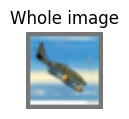

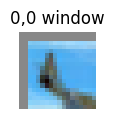

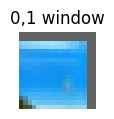

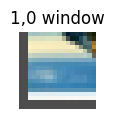

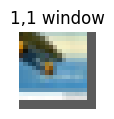

In [11]:
# show results on image
ic(x.shape)
nb_win = 2
win_size = int(x.shape[-1]/nb_win)

ux = x.unfold(2,win_size,win_size).unfold(3,win_size,win_size)
ic(ux.shape)
show_image(x[0],"Whole image")

def show_image_windows(unfolded_x, max_nb:int=-1):
    nb : int = 1
    for h in range(0,unfolded_x.shape[2]):
        for w in range(0,unfolded_x.shape[3]):
            show_image(unfolded_x[0,:,h,w,:,:], f"{h},{w} window");            
            nb += 1
            if (max_nb>0) & (nb >= max_nb):
                return
            

show_image_windows(ux, max_nb=-1)

ic|

 out_channels: 3, in_channels: 3, kernel_height: 3, kernel_width: 3
ic| flatten_unfolded_input.shape: torch.Size([1, 3, 1156, 9])


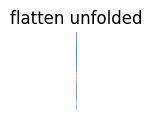

ic| flatten_unfolded_input_reshaped: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6549],
                                             [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6549, 0.6392],
                                             [0.0000, 0.0000, 0.0000,  ..., 0.6549, 0.6392, 0.6549],
                                             ...,
                                             [0.7961, 0.7804, 0.7882,  ..., 0.0000, 0.0000, 0.0000],
                                             [0.7804, 0.7882, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
                                             [0.7882, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
                                            device='mps:0')
ic| weight_reshaped.shape: torch.Size([27, 3])
ic| flatten_output.shape: torch.Size([1156, 3])
ic| output.shape: torch.Size([1, 3, 34, 34])


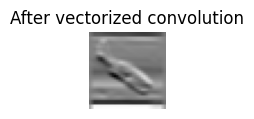

In [14]:
batch_size, in_channels, in_height, in_width = x.shape
out_channels, in_channels, kernel_height, kernel_width = kernel_weight.shape
ic(out_channels, in_channels, kernel_height,kernel_width)
# Calculate output dimensions
out_height = (in_height - kernel_height) // stride + 1
out_width = (in_width - kernel_width) // stride + 1

# # Extract sliding local blocks
input_unfolded = x.unfold(2, kernel_height, stride).unfold(3, kernel_width, stride)
#show_image_windows(input_unfolded, max_nb=5)

# Flatten sliding blocks
flatten_unfolded_input=input_unfolded.contiguous().view(batch_size, in_channels, out_height * out_width, kernel_height * kernel_width)
ic(flatten_unfolded_input.shape)
show_image(flatten_unfolded_input,"flatten unfolded")

 # Reshape for matrix multiplication
flatten_unfolded_input_reshaped = flatten_unfolded_input.permute(0, 2, 1, 3).contiguous().view(batch_size * out_height * out_width, in_channels * kernel_height * kernel_width)
ic(flatten_unfolded_input_reshaped)
weight_reshaped = kernel_weight.view(out_channels, -1).t()
ic(weight_reshaped.shape)

# Perform matrix multiplication and add bias
flatten_output = torch.matmul(flatten_unfolded_input_reshaped, weight_reshaped)
ic(flatten_output.shape)
output = flatten_output.view(batch_size, out_height, out_width, out_channels).permute(0, 3, 1, 2)
ic(output.shape)   
show_image(output, "After vectorized convolution")

https://github.com/MishaLaskin/vqvae/tree/master

## Pooling

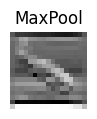

In [15]:

def max_pool2d(input, kernel_size, stride):
    batch_size, channels, height, width = input.size()
    output_height = (height - kernel_size) // stride + 1
    output_width = (width - kernel_size) // stride + 1
    
    output = torch.zeros((batch_size, channels, output_height, output_width), device=input.device)
    
    for b in range(batch_size):
        for c in range(channels):
            for i in range(0, height - kernel_size + 1, stride):
                for j in range(0, width - kernel_size + 1, stride):
                    h_start, h_end = i, i + kernel_size
                    w_start, w_end = j, j + kernel_size
                    output[b, c, i // stride, j // stride] = torch.max(input[b, c, h_start:h_end, w_start:w_end])
                    
    return output

# Example usage

max_output = max_pool2d(output, kernel_size=2, stride=2)
show_image(max_output,"MaxPool")

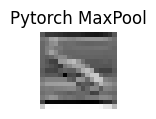

In [16]:
# Check if pytorch maxpool is the same. 
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

# Apply the Max Pooling layer to the input tensor
max_output = max_pool(output)
show_image(max_output,"Pytorch MaxPool")

## Vectorized vesion

1. Unfold : unfold is used to extract sliding local blocks from the input tensor. This creates a tensor where each window of size kernel_size x kernel_size is extracted according to the stride.

2. Reshape: The tensor is reshaped to merge the kernel dimensions, preparing it for the max operation.

3. Max Operation: The max operation is applied over the last dimension, which contains the elements of each kernel window, to get the maximum values.

In [17]:
kernel_size=2
stride=2
unfold = output.unfold(2, kernel_size,stride)
ic(output.shape)
ic(unfold.shape)

ic| output.shape: torch.Size([1, 3, 34, 34])
ic| unfold.shape: torch.

Size([1, 3, 17, 34, 2])


torch.Size([1, 3, 17, 34, 2])

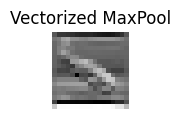

In [18]:
def vectorized_max_pool2d(input, kernel_size, stride):
    # Use unfold to extract sliding local blocks from a batched input tensor
    unfolded = input.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
    # Now unfolded tensor has shape: (batch_size, channels, output_height, output_width, kernel_size, kernel_size)
    # Reshape to merge the kernel dimensions
    unfolded = unfolded.contiguous().view(*unfolded.size()[:4], -1)
    # Apply max operation over the last dimension (which contains the kernel elements)
    output, _ = unfolded.max(dim=-1)
    return output

max_output = vectorized_max_pool2d(output, kernel_size=2, stride=2)
show_image(max_output,"Vectorized MaxPool")